In [587]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import re
import string
import spacy
import colorlover as cl
import random
import shap

from wordcloud import WordCloud
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from plotly.subplots import make_subplots
from spacy import displacy
from nltk.tokenize import TreebankWordTokenizer as twt
from nltk.tokenize import TweetTokenizer as twt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [588]:
train_data = pd.read_csv('data/train.csv')

Columns (112,114,121,125,157,168,186,188,206,208,217,229,231,232,233,235,237,241,244,246,247,249,250,251,268,270,271,280,282,286,288,289,291,305,310,312,313,315,316,318,319,323,324,327,328,329,331,333,335,336,338,342,344,348,350,352,353,355,356,358,359,361) have mixed types. Specify dtype option on import or set low_memory=False.


In [589]:
train_data.columns

Index(['id', 'context', 'is_mult_event', 'annotations/0/events/0/event_id',
       'annotations/0/events/0/event_type',
       'annotations/0/events/0/Trigger/text/0/0',
       'annotations/0/events/0/Trigger/start/0/0',
       'annotations/0/events/0/Trigger/entity_id/0',
       'annotations/0/events/0/Treatment/text/0/0',
       'annotations/0/events/0/Treatment/start/0/0',
       ...
       'annotations/0/events/3/Subject/entity_id/0',
       'annotations/0/events/3/Subject/Population/text/0/0',
       'annotations/0/events/3/Subject/Population/start/0/0',
       'annotations/0/events/3/Subject/Population/entity_id/0',
       'annotations/0/events/0/Treatment/Dosage/text/3/0',
       'annotations/0/events/0/Treatment/Dosage/start/3/0',
       'annotations/0/events/0/Treatment/Dosage/entity_id/3',
       'annotations/0/events/0/Treatment/Combination/0/Drug/text/5/0',
       'annotations/0/events/0/Treatment/Combination/0/Drug/start/5/0',
       'annotations/0/events/0/Treatment/Combi

In [590]:
# Selected columns to be retained and rename them
selected_columns = ['id', 'context', 'annotations/0/events/0/event_type', 
                    'annotations/0/events/0/Trigger/text/0/0', 
                    'annotations/0/events/0/Treatment/Drug/text/0/0','annotations/0/events/0/Effect/text/0/0']
new_names = ['id', 'context', 'event_type', 'trigger_text', 'drug', 'drug_effect']
train_df = train_data[selected_columns].rename(columns=dict(zip(selected_columns, new_names)))

In [591]:
sentiment_mapping = {'Adverse_event': 1, 'Potential_therapeutic_event': 0}
train_df['sentiment'] = train_df['event_type'].map(sentiment_mapping)

In [592]:
train_df.sample(5)

,id,context,event_type,trigger_text,drug,drug_effect,sentiment
296,11207969_4,We report a fatal case of toxic epidermal necr...,Adverse_event,resulting from,cytosine arabinoside (ARA-C),toxic epidermal necrolysis (TEN),1
2525,17536204_5,The patient developed grade 3 capecitabine-ind...,Adverse_event,induced,capecitabine,headache,1
623,7351000_4,The probability of developing acute leukemia i...,Adverse_event,developing,Treosulfan,acute leukemia,1
1399,19904536_1,Fatal gemcitabine-induced pulmonary toxicity i...,Adverse_event,induced,gemcitabine,pulmonary toxicity,1
1478,14690166_6,"Therefore, it is reasonable to conclude that: ...",Potential_therapeutic_event,induce,2-CdA,durable complete remission,0


In [594]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'([^\x00-\x7F])+', ' ', text)
    return text

def get_most_common_words(df):
    stop = set(stopwords.words("english"))
    corpus = [word for text in df["context_clean"] for word in word_tokenize(text) if word not in stop]
    most_common = Counter(corpus).most_common(10)
    words, frequency = zip(*most_common)
    return words, frequency

def get_ngram_freq(n, df):
    vec = CountVectorizer(stop_words=stopwords.words("english"), ngram_range=(n, n))
    bow = vec.fit_transform(df["context_clean"])
    count_values = bow.toarray().sum(axis=0)
    ngram_freq = pd.DataFrame(zip(count_values, vec.get_feature_names()), columns=["frequency", "ngram"])
    ngram_freq.sort_values(by="frequency", ascending=False, inplace=True)
    return ngram_freq

def analyze_rare_words(text_data, top_k=10, threshold=5):
    combined_text = ' '.join(text_data)
    words = word_tokenize(combined_text)
    word_counts = Counter(words)
    rare_words = [word for word, count in word_counts.items() if count <= threshold]
    rare_words = sorted(rare_words, key=lambda x: word_counts[x], reverse=True)
    return rare_words[:top_k]

In [595]:
train_df["char_count"] = train_df["context"].str.len()
train_df["word_count"] = train_df["context"].apply(lambda x: len(x.split()))
train_df["sent_count"] = train_df["context"].apply(lambda x: len(sent_tokenize(x)))
train_df["rare_words"] = train_df["context"].apply(analyze_rare_words)
train_df["avg_word_len"] = train_df["context"].apply(lambda x: np.mean([len(w) for w in x.split()]))
train_df["avg_sent_len"] = train_df["context"].apply(lambda x: np.mean([len(w.split()) for w in sent_tokenize(x)]))
train_df["context_clean"] = train_df["context"].apply(preprocess_text)

In [596]:
train_df.sample(5)

,id,context,event_type,trigger_text,drug,drug_effect,sentiment,char_count,word_count,sent_count,rare_words,avg_word_len,avg_sent_len,context_clean
2822,11144696_3,A 25-year-old white woman with chronic depress...,Potential_therapeutic_event,treated,venlafaxine,NaN,0,113,17,1,"[w, m, o, h, 5, s, -, l, c, p]",5.705882,17.0,a 25yearold white woman with chronic depressio...
2237,889156_1,The use of beclomethasone diproprionate inhale...,Adverse_event,development,beclomethasone diproprionate,eosinophilic pneumonia reaction,1,117,15,1,"[h, c, l, m, r, s, d, u, f, b]",6.866667,15.0,the use of beclomethasone diproprionate inhale...
1595,2894766_2,Physicians who use sulfasalazine to treat pati...,Adverse_event,induced,sulfasalazine,lupus syndrome,1,152,21,1,"[h, f, d, w, r, y, m, c, z, p]",6.285714,21.0,physicians who use sulfasalazine to treat pati...
2489,17655517_2,Linezolid is an oxazolidinone antibacterial ag...,Potential_therapeutic_event,indicated,Linezolid,NaN,0,97,11,1,"[s, d, r, l, c, z, g, f, L, x]",7.909091,11.0,linezolid is an oxazolidinone antibacterial ag...
1412,6408978_1,Intravenous diazepam exacerbated the seizures.,Adverse_event,exacerbated,diazepam,seizures,1,46,5,1,"[a, t, r, s, n, u, d, i, z, I]",8.400000,5.0,intravenous diazepam exacerbated the seizures


In [597]:
train_df.describe()

,sentiment,char_count,word_count,sent_count,avg_word_len,avg_sent_len
count,2898.000000,2898.000000,2898.000000,2898.000000,2898.000000,2898.000000
mean,0.914424,134.912353,18.417184,1.004141,6.761856,18.355245
std,0.279786,61.001338,9.155366,0.064227,1.506370,9.062168
min,0.000000,24.000000,2.000000,1.000000,3.647059,2.000000
25%,1.000000,90.000000,12.000000,1.000000,5.866667,12.000000
50%,1.000000,126.000000,17.000000,1.000000,6.444444,17.000000
75%,1.000000,170.750000,24.000000,1.000000,7.250000,24.000000
max,1.000000,527.000000,74.000000,2.000000,18.500000,70.000000


In [599]:
selected_column = 'event_type'

# Count unique values in each column
unique_values = train_df[selected_column].value_counts()

# Create a bar chart using Plotly
fig = go.Figure(data=[go.Bar(x=unique_values.index, y=unique_values.values,
                            text=unique_values.values, textposition='auto')])
fig.update_layout(title=f'Unique Values in: {selected_column}',
                  xaxis_title='Unique Values', yaxis_title='Count')

### Note for Savio ... Do i need to address class imbalance? There is more negative sentiment in the training set as compared to the positive sentiment. Is there a technique that i can use in NLP to address this imbalance...

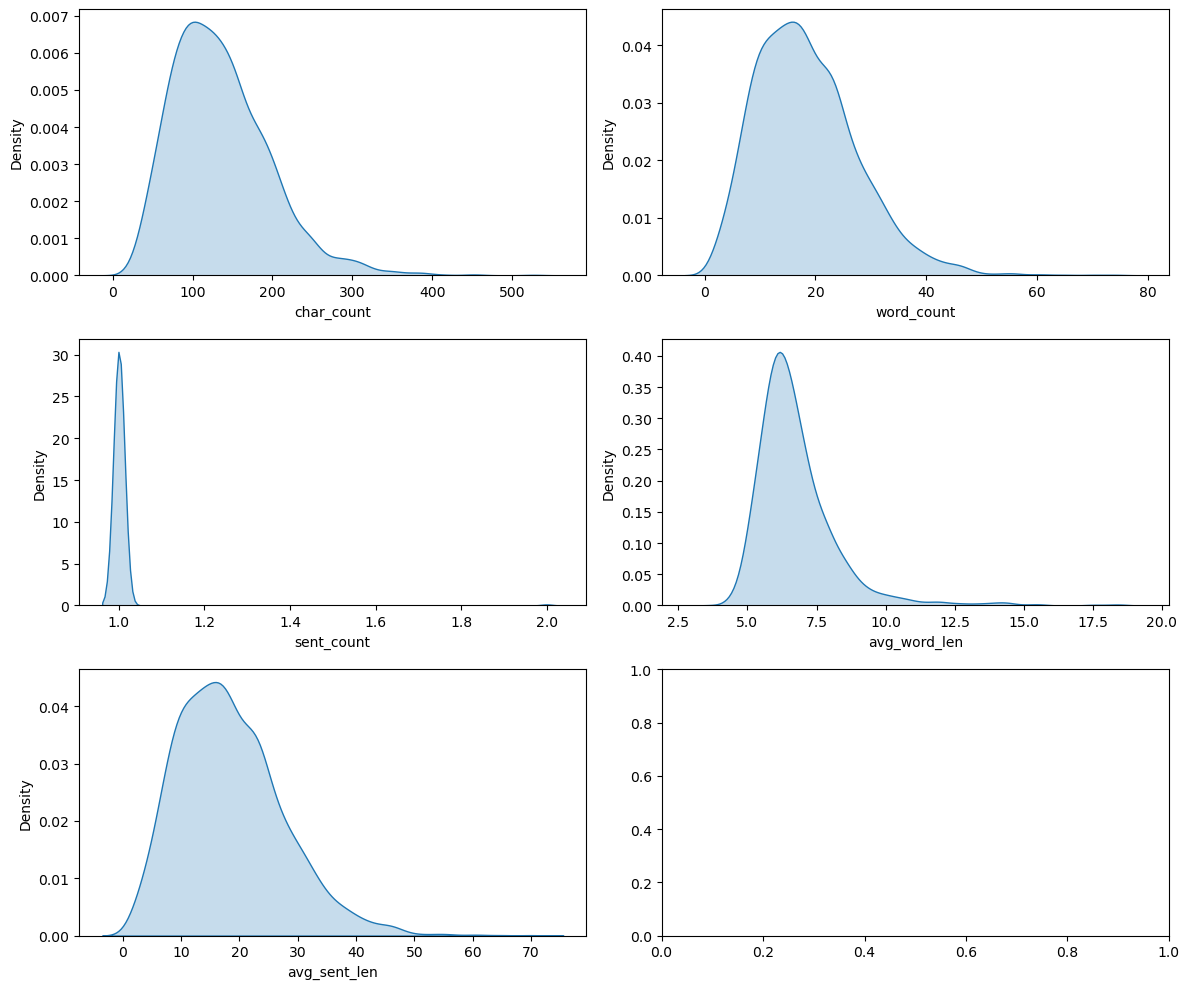

In [600]:
# Set the number of columns and rows for the subplots
num_columns = 2
num_rows = 3

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 10))
axes = axes.ravel()

interesting_columns = ['char_count', 'word_count', 'sent_count', 'avg_word_len', 'avg_sent_len']
# Generate KDE subplots for each column

for i, column in enumerate(interesting_columns):
    sns.kdeplot(data=df[column], shade=True, ax=axes[i])
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Density')

# Adjust spacing and display the subplots
plt.tight_layout()
plt.show()

In [601]:
def create_corpus(df, column_name):
    stop = set(stopwords.words("english"))
    corpus = [word for i in df[column_name].str.split().values.tolist() for word in i if word not in stop]
    return corpus

In [602]:
corpus = create_corpus(train_df, "context_clean")

<AxesSubplot:>

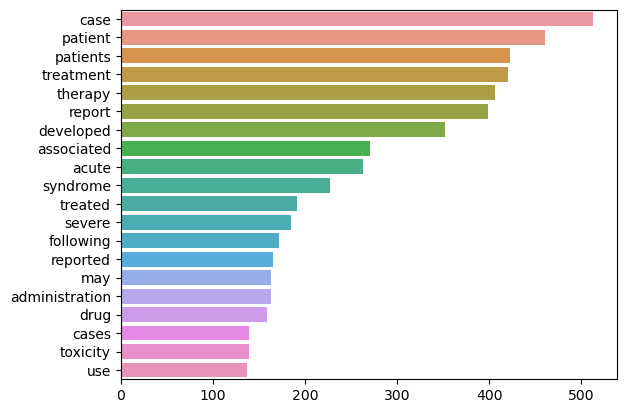

In [603]:
most_common = Counter(corpus).most_common(20)

words, frequency = [], []
for word, count in most_common:
    words.append(word)
    frequency.append(count)
    
sns.barplot(x = frequency, y = words)

In [604]:
positive_event_to_match = 'Potential_therapeutic_event'
positive_df = train_df[train_df['event_type'] == positive_event_to_match]
positive_corpus = create_corpus(positive_df, "context_clean")

In [605]:
positive_df[0:5]

,id,context,event_type,trigger_text,drug,drug_effect,sentiment,char_count,word_count,sent_count,rare_words,avg_word_len,avg_sent_len,context_clean
71,19537383_2,"Sorafenib, a multitargeted kinase inhibitor us...",Potential_therapeutic_event,treatment,Sorafenib,NaN,0,174,23,1,"[m, u, s, f, b, h, p, v, ,, 0]",6.608696,23.0,sorafenib a multitargeted kinase inhibitor use...
80,23624139_10,Risks and benefits of co-treatment should be c...,Potential_therapeutic_event,recommended,NSAIDs,in order to improve DDAVP safety,0,188,28,1,"[f, m, h, u, D, b, p, y, v, A]",5.750000,28.0,risks and benefits of cotreatment should be ca...
81,15685264_6,She had been treated by Carbamazepine 1000 mg/...,Potential_therapeutic_event,treated,Carbamazepine,NaN,0,132,21,1,"[y, h, b, c, d, p, 0, f, s, l]",5.333333,21.0,she had been treated by carbamazepine 1000 mgd...
91,7787496_1,Sotalol-induced bradycardia reversed by glucagon.,Potential_therapeutic_event,reversed,glucagon,NaN,0,49,5,1,"[a, d, e, r, o, l, c, i, n, u]",9.000000,5.0,sotalolinduced bradycardia reversed by glucagon
114,10660641_2,A patient treated with itraconazole (ITCZ) und...,Potential_therapeutic_event,treated,itraconazole,NaN,0,143,17,1,"[l, u, g, A, f, y, w, z, (, I]",7.470588,17.0,a patient treated with itraconazole itcz under...


<AxesSubplot:>

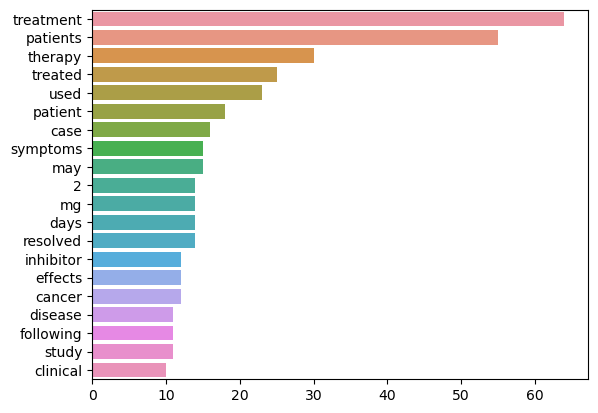

In [606]:
common_pos_words = Counter(positive_corpus).most_common(20)

words, frequency = [], []
for word, count in common_pos_words:
    words.append(word)
    frequency.append(count)
    
sns.barplot(x = frequency, y = words)

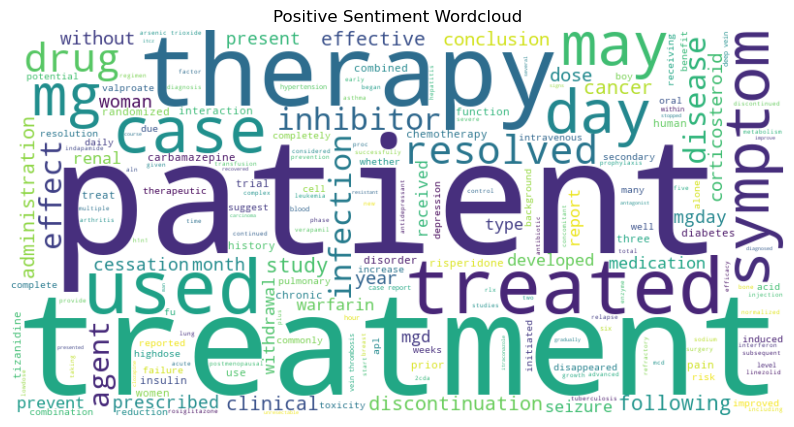

In [633]:
# Postive sentiment word cloud
text = ' '.join(positive_df['context_clean'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment Wordcloud')
plt.show()

In [607]:
negative_event_to_match = 'Adverse_event'
negative_df = train_df[train_df['event_type'] == negative_event_to_match]
negative_corpus = create_corpus(negative_df, "context_clean")

In [608]:
negative_df[0:5]

,id,context,event_type,trigger_text,drug,drug_effect,sentiment,char_count,word_count,sent_count,rare_words,avg_word_len,avg_sent_len,context_clean
0,8908396_3,OBJECTIVE: To test the hypothesis that tumor n...,Adverse_event,induced,insulin,lipoatrophies,1,238,33,1,"[c, l, T, m, E, y, -, b, O, B]",6.242424,33.0,objective to test the hypothesis that tumor ne...
1,10891991_1,An evaluation of ovarian structure and functio...,Adverse_event,develop,valproate,menstrual cycle disturbances,1,214,30,1,"[v, f, y, h, b, m, g, w, A, ,]",6.166667,30.0,an evaluation of ovarian structure and functio...
2,2332596_1,Phenobarbital hepatotoxicity in an 8-month-old...,Adverse_event,in,Phenobarbital,hepatotoxicity,1,54,6,1,"[o, a, i, h, e, b, l, -, P, r]",8.166667,6.0,phenobarbital hepatotoxicity in an 8monthold i...
3,12552054_1,The authors report a case of Balint syndrome w...,Adverse_event,following,methotrexate,Balint syndrome with irreversible posterior le...,1,150,19,1,"[s, p, c, y, u, f, d, m, w, b]",6.947368,19.0,the authors report a case of balint syndrome w...
4,19531695_12,"According to the Naranjo probability scale, fl...",Adverse_event,cause,flecainide,delirium,1,237,31,1,"[h, u, g, f, y, w, m, A, N, j]",6.677419,31.0,according to the naranjo probability scale fle...


<AxesSubplot:>

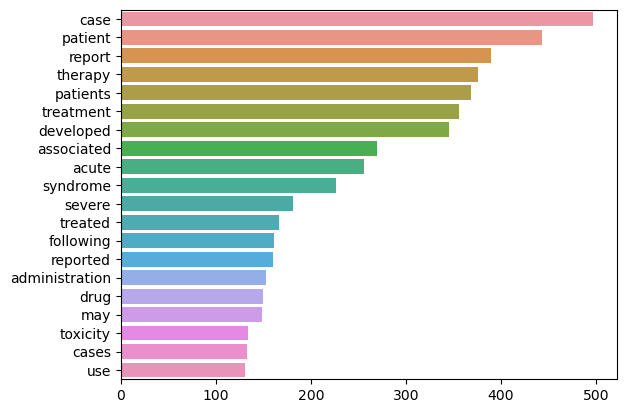

In [609]:
common_negative_words = Counter(negative_corpus).most_common(20)

words, frequency = [], []
for word, count in common_negative_words:
    words.append(word)
    frequency.append(count)
    
sns.barplot(x = frequency, y = words)

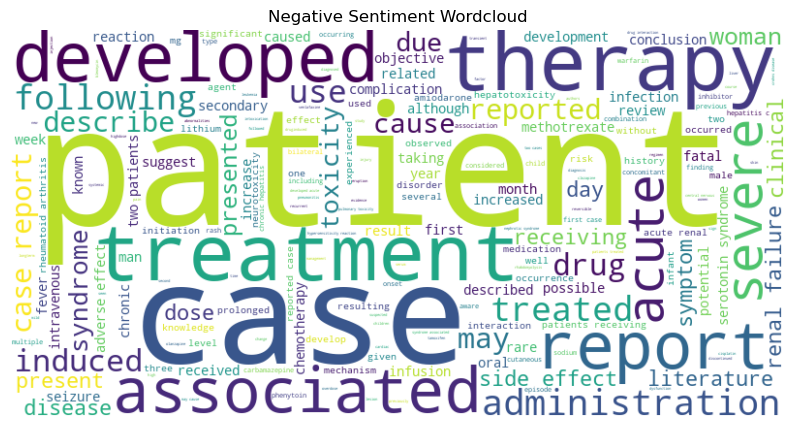

In [632]:
text = ' '.join(negative_df['context_clean'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment Wordcloud')
plt.show()

In [610]:
def extract_top_ngrams(df, column_name, n_gram_range=(2, 3), top_n=10):
    vectorizer = CountVectorizer(ngram_range=n_gram_range)
    X = vectorizer.fit_transform(df[column_name])
    feature_names = vectorizer.get_feature_names_out()
    ngram_counts = X.sum(axis=0)
    sorted_ngrams = sorted([(count, ngram) for ngram, count in zip(feature_names, ngram_counts.tolist()[0])], 
                           reverse=True)
    
    result_df = pd.DataFrame(sorted_ngrams[:top_n], columns=['Frequency', 'N-gram'])
    return result_df

In [611]:
top_ngrams_df = extract_top_ngrams(train_df, 'context_clean', n_gram_range=(2, 2), top_n=10)
top_ngrams_df

,Frequency,N-gram
0,294,case of
1,258,associated with
2,248,of the
3,190,in the
4,174,we report
5,169,patient with
6,152,treated with
7,143,treatment with
8,127,in patient
9,119,who developed


In [612]:
top_neg_ngrams_df = extract_top_ngrams(negative_df, 'context_clean', n_gram_range=(2, 3), top_n=10)
top_neg_ngrams_df

,Frequency,N-gram
0,288,case of
1,256,associated with
2,230,of the
3,169,we report
4,164,patient with
5,160,in the
6,131,treated with
7,130,treatment with
8,124,in patient
9,116,who developed


In [613]:
top_pos_ngrams_df = extract_top_ngrams(pos_df, 'context_clean', n_gram_range=(2, 3), top_n=10)
top_pos_ngrams_df

,Frequency,N-gram
0,33,treatment of
1,30,in the
2,24,the treatment of
3,24,the treatment
4,23,patients with
5,21,treated with
6,18,of the
7,16,for the
8,14,in the treatment
9,13,treatment with


In [614]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['Top N-grams for Negative Sentiment', 
                                                    'Top N-grams for Positive Sentiment'], 
                    horizontal_spacing=0.3, vertical_spacing=0.3)

fig.add_trace(go.Bar(x=top_neg_ngrams_df['Frequency'], y=top_neg_ngrams_df['N-gram'], 
                     orientation='h', name='Negative Sentiment', marker_color='red'), row=1, col=1)

fig.add_trace(go.Bar(x=top_pos_ngrams_df['Frequency'], y=top_pos_ngrams_df['N-gram'], 
                     orientation='h', name='Positive Sentiment', marker_color='blue'), row=1, col=2)

fig.update_layout(title='Comparison of Top N-grams for Positive and Negative Sentiment')
fig.show()

In [615]:
# overlapping statements ...
fig = go.Figure()

fig.add_trace(go.Bar(
    y=top_neg_ngrams_df['N-gram'],
    x=top_neg_ngrams_df['Frequency'],
    name='Negative Sentiment',
    orientation='h',
    marker_color='red'
))

fig.add_trace(go.Bar(
    y=top_pos_ngrams_df['N-gram'],
    x=top_pos_ngrams_df['Frequency'],
    name='Positive Sentiment',
    orientation='h',
    marker_color='blue'
))

fig.update_layout(
    title='Comparison of Top N-grams for Positive and Negative Sentiment',
    barmode='group'
)

fig.show()

In [616]:
def visualize_pos(dataframes, dataframe_names, column):
    pos_tags = ["ADJ"]

    # Download and load the spaCy English language model
    try:
        nlp = spacy.load("en_core_web_sm")
    except OSError:
        print("Downloading language model. This may take a while...")
        spacy.cli.download("en_core_web_sm")
        nlp = spacy.load("en_core_web_sm")

    # Tokenize text and perform POS tagging
    tokenizer = twt()
    adjectives_by_dataframe = {}
    color_palette = cl.scales['12']['qual']['Set3']
    random.shuffle(color_palette)

    for i, dataframe in enumerate(dataframes):
        tokens = dataframe[column].apply(lambda x: tokenizer.tokenize(x))
        docs = tokens.apply(lambda x: nlp(" ".join(x)))
        tags = docs.apply(lambda doc: [token.lemma_ for token in doc if token.pos_ in pos_tags])
        adjectives = [adj for sublist in tags for adj in sublist]
        adjectives_counter = Counter(adjectives)
        top_adjectives = adjectives_counter.most_common(10)
        adjectives_by_dataframe[dataframe_names[i]] = top_adjectives

    # Create a bar chart for each dataframe
    fig = make_subplots(rows=len(dataframes), cols=1, subplot_titles=dataframe_names, vertical_spacing=0.3)

    for i, dataframe_name in enumerate(dataframe_names):
        top_adjectives = adjectives_by_dataframe[dataframe_name]
        x = [adj[0] for adj in top_adjectives]
        y = [adj[1] for adj in top_adjectives]
        colors = random.choices(color_palette, k=len(top_adjectives))

        fig.add_trace(go.Bar(x=x, y=y, marker=dict(color=colors)), row=i+1, col=1)

        # Add annotations to the bar chart for the top adjectives
        for xi, yi in zip(x, y):
            fig.add_annotation(
                x=xi,
                y=yi,
                text=str(yi),
                showarrow=False,
                font=dict(size=10)
            )

    fig.update_layout(title="Top 10 Adjectives by Dataframe",
                      xaxis_title="Adjective",
                      yaxis_title="Count",
                      showlegend=False)

    fig.update_xaxes(tickangle=-45, tickfont=dict(size=8))
    fig.update_yaxes(tickfont=dict(size=8))

    fig.show()

In [617]:
dataframes = [negative_df, positive_df]
dataframe_names = ["Negative Sentiments", "Positive Sentiments"]
column = "context_clean"

visualize_pos(dataframes, dataframe_names, column)

In [634]:
fig = go.Figure(data=go.Scatter(x=train_df['word_count'], y=train_df['sentiment'],
                               mode='markers', marker=dict(color=train_df['sentiment'],
                                                            colorscale='RdYlBu',
                                                            colorbar=dict(title='Sentiment'),
                                                            cmin=0, cmax=1)))

fig.update_layout(xaxis_title='Word Count', yaxis_title='Sentiment Score',
                  title='Word Count vs Sentiment Score', showlegend=False)

fig.add_trace(go.Scatter(x=[], y=[], mode='markers', marker=dict(color='blue'), showlegend=True,
                         legendgroup='Positive Sentiment', name='Positive Sentiment (0)'))
fig.add_trace(go.Scatter(x=[], y=[], mode='markers', marker=dict(color='red'), showlegend=True,
                         legendgroup='Negative Sentiment', name='Negative Sentiment (1)'))


fig.show()